In [ ]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph

# Load Envs

In [ ]:
import os
from google.colab import userdata
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

# Structured Output

It is often crucial to have LLMs return structured output. This is because oftentimes the outputs of the LLMs are used in downstream applications, where specific arguments are required. Having the LLM return structured output reliably is necessary for that.

There are a few different high level strategies that are used to do this:

1. Prompting: This is when you ask the LLM (very nicely) to return output in the desired format (JSON, XML). This is nice because it works with all LLMs. It is not nice because there is no guarantee that the LLM returns the output in the right format.
2. Function calling: This is when the LLM is fine-tuned to be able to not just generate a completion, but also generate a function call. The functions the LLM can call are generally passed as extra parameters to the model API. The function names and descriptions should be treated as part of the prompt (they usually count against token counts, and are used by the LLM to decide what to do).
3. Tool calling: A technique similar to function calling, but it allows the LLM to call multiple functions at the same time.
4. JSON mode: This is when the LLM is guaranteed to return JSON.

Different models may support different variants of these, with slightly different parameters. In order to make it easy to get LLMs to return structured output, we have added a common interface to LangChain models: `.with_structured_output`.

By invoking this method (and passing in a JSON schema or a Pydantic model) the model will add whatever model parameters + output parsers are necessary to get back the structured output. There may be more than one way to do this (e.g., function calling vs JSON mode) - you can configure which method to use by passing into that method.


### [structured output v0](https://python.langchain.com/v0.1/docs/modules/model_io/chat/structured_output/)

### [structured output v3](https://python.langchain.com/docs/concepts/structured_outputs/)

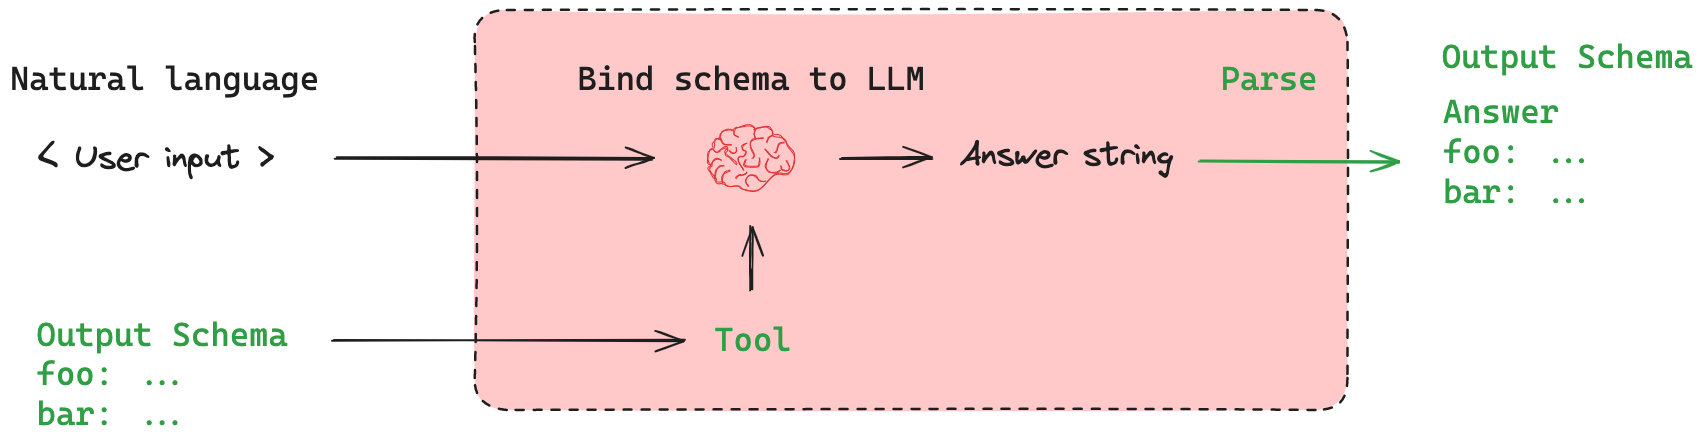

In [ ]:
from pydantic import BaseModel, Field

# Use Pydantic to easily structure the response schema.
class Joke(BaseModel):
    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")

In [ ]:
structured_llm = llm.with_structured_output(Joke) # By default, we will use function_calling

In [ ]:
structured_llm.invoke("Tell me a joke about cats")

Joke(setup='Why was the cat sitting on the computer?', punchline='To keep an eye on the mouse!')

In [ ]:
# JSON Mode
structured_llm = llm.with_structured_output(Joke, method="json_mode")

In [ ]:
# Note that we need to specify in the prompt the format that it should respond in.
structured_llm.invoke(
    "Tell me a joke about cats, respond in JSON with `setup` and `punchline` keys"
)

Joke(setup='Why was the cat sitting on the computer?', punchline='He wanted to keep an eye on the mouse!')

In [ ]:
result = structured_llm.invoke("Tell me a joke about cats, respond in JSON with `setup` and `punchline` keys")

In [ ]:
result

Joke(setup='Why was the cat sitting on the computer?', punchline='To keep an eye on the mouse!')

In [ ]:
type(result)

__main__.Joke

# Build Agent

## Adding Memory to Agent

In [94]:
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Add Structured Output Method

In [95]:
from pydantic import BaseModel, Field

In [96]:
class OutputStructure(BaseModel):
  header: str = Field(description="The header of the response")
  subheader: str = Field(description="The subheader of the response")
  body: str = Field(description="The body of the response")

Bind the schema to the model

In [97]:
llm_with_structure = llm.with_structured_output(OutputStructure)

Inherit the OutputStructure in State of Langgraph

In [98]:
# Inherit the key 'messages' from MessagesState, which is a list of chat messages
class State(MessagesState):
  # Final output in a structured format from llm
  final_output_structure: OutputStructure

## Tools

In [99]:
# Prebuilt Tools

from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [100]:
# Custom Tools

from langchain_core.tools import tool

@tool
def random_func(user_input: str) -> str:
  """
  Surprises user with a random fact.

  Args:
    user_input: string.

  Returns:
    A random fact: String.
  """
  random_prompt = "Surprise the user with something random about {user_input}".format(user_input=user_input)
  return llm.predict(random_prompt)

In [101]:
tools = [search, wikipedia, random_func]

Bind Tools

In [102]:
llm_with_tools = llm.bind_tools(tools)

Tool Node

In [103]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)

## Agents

In [104]:
def agentic_func(state: State):
  print("------------ Tool Calling Func ----------")

  query = state['messages'] # pass the entire state as a query

  result = llm_with_tools.invoke(query)

  return {"messages" : [result]}

In [105]:
from langchain_core.messages import HumanMessage

def agent_response(state: State):
  print("------------ Agent Response Func ----------")

  # print(state)
  # print("---------")

  # print(state['messages'][-1].content)
  # print("---------")

  ip = state['messages'][-1].content

  ip_message = [HumanMessage(content=ip)]

  # print(ip_message)
  # print("---------")

  response = llm_with_structure.invoke(ip_message)

  # print("final_output_structure: ", response)

  return {"final_output_structure" : response}

## Route

In [106]:
from typing import Literal

def router(state: State) -> Literal["Call Tool", "Final Response"]:
  print("---------- Router ----------")

  tool_identified = state["messages"][-1]


  if tool_identified.tool_calls:
    return "Call Tool"

  return "Final Response"

# Build Graph

In [118]:
from langgraph.graph import START, END, StateGraph

In [119]:
# 1. Create Instance of the Graph
workflow = StateGraph(State)


# 2. Create Nodes
workflow.add_node("Agent", agentic_func)
workflow.add_node("Tools", tool_node)
workflow.add_node("Agent Response", agent_response)


# 3. Create Conditional Edges
workflow.add_conditional_edges(
    "Agent",   # Tool Calling
    router, # The routing function
    {
        "Call Tool" : "Tools",
        "Final Response" : "Agent Response"
    }
)

## Create Cyclic Edge
workflow.add_edge("Tools", "Agent")

## Create Entry Point
workflow.add_edge(START, "Agent")

## Create End Point
workflow.add_edge("Agent Response", END)

# 4. Compile the Graph
my_graph = workflow.compile(checkpointer=memory) # add memory here

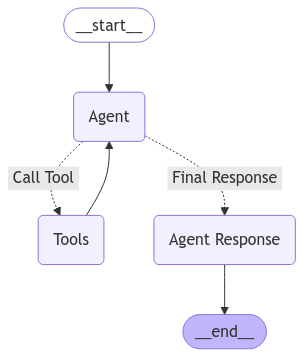

In [120]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

# Run Graph

In [125]:
config = {"configurable": {"thread_id": "1"}}

In [126]:
user_input = "Tell me about AI Agents."

In [127]:
result = my_graph.invoke(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)


------------ Tool Calling Func ----------
---------- Router ----------


<ipython-input-100-0e163f59bca2>:17: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return llm.predict(random_prompt)


------------ Tool Calling Func ----------
---------- Router ----------
------------ Agent Response Func ----------


In [128]:
result

{'messages': [HumanMessage(content='Tell me about AI Agents.', additional_kwargs={}, response_metadata={}, id='8a9b8c1f-54b3-4292-8601-3b57904bbc77'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8P0mycjEfbkG4OVPD6tGyGoQ', 'function': {'arguments': '{"query":"AI Agents"}', 'name': 'wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 187, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3778f17f-b5aa-4e37-a39e-f975bf56193f-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'AI Agents'}, 'id': 'call_8P0mycjEfbkG4OVPD6tGyGoQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 187, '

In [134]:
result['final_output_structure']

OutputStructure(header='Artificial Intelligence in Board Games', subheader='AI agents excel in complex board games', body='AI agents have been trained to play complex board games like Go and Chess at a superhuman level. They have even defeated world champions in these games, demonstrating the impressive abilities of artificial intelligence in strategic thinking and decision-making.')

In [138]:
type(result['final_output_structure'])

__main__.OutputStructure

In [136]:
result['final_output_structure'].header

'Artificial Intelligence in Board Games'

In [137]:
result['final_output_structure'].body

'AI agents have been trained to play complex board games like Go and Chess at a superhuman level. They have even defeated world champions in these games, demonstrating the impressive abilities of artificial intelligence in strategic thinking and decision-making.'

# Agent Resonse will have a state in this strucure

In [133]:
'''
{'messages':
  [
    HumanMessage(
      content='Tell me about AI Agents.',
      additional_kwargs={},
      response_metadata={},
      id='cb088ec0-b1c1-4848-95e5-09a70db35bbc'
    ),

    AIMessage(
      content='',
      additional_kwargs={
        'tool_calls': [{
          'id': 'call_bEwhpIZYz0QXQlC5iBicXp9A',
          'function': {
            'arguments': '{"query":"AI Agents"}', 'name': 'wikipedia'
            },
          'type': 'function'
        }],
        'refusal': None
      },
      response_metadata={
        'token_usage': {
          'completion_tokens': 15,
          'prompt_tokens': 187,
          'total_tokens': 202,
          'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0},
          'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
        },
        'model_name': 'gpt-3.5-turbo-0125',
        'system_fingerprint': None,
        'finish_reason': 'tool_calls',
        'logprobs': None
      },
      id='run-77347958-a8ed-488c-8340-60cb475b8bb6-0',
      tool_calls=[{
        'name': 'wikipedia',
        'args': {'query': 'AI Agents'},
        'id': 'call_bEwhpIZYz0QXQlC5iBicXp9A',
        'type': 'tool_call'
      }],
      usage_metadata={
        'input_tokens': 187,
        'output_tokens': 15,
        'total_tokens': 202,
        'input_token_details': {'audio': 0, 'cache_read': 0},
        'output_token_details': {'audio': 0, 'reasoning': 0}
        }
    ),

    ToolMessage(
      content='Page: Intelligent agent\nSummary: In intelligence and artificial intelligence, an intelligent agent (IA) is an agent that perceives its environment, takes actions autonomously in order to achieve goals, and may improve its performance with learning or acquiring knowledge. \nAn intelligent agent may be simple or complex: A thermostat or other control system is considered an example of an intelligent agent, as is a human being, as is any system that meets the definition, such as a firm, a state, or a biome.\n\nLeading AI textbooks define "artificial intelligence" as the "study and design of intelligent agents", a definition that considers goal-directed behavior to be the essence of intelligence. Goal-directed agents are also described using a term borrowed from economics, "rational agent".\nAn agent has an "objective function" that encapsulates all the IA\'s goals. Such an agent is designed to create and execute whatever plan will, upon completion, maximize the expected value of the objective function. \nFor example, a reinforcement learning agent has a "reward function" that allows the programmers to shape the IA\'s desired behavior, and an evolutionary algorithm\'s behavior is shaped by a "fitness function". \nIntelligent agents in artificial intelligence are closely related to agents in economics, and versions of the intelligent agent paradigm are studied in cognitive science, ethics, and the philosophy of practical reason, as well as in many interdisciplinary socio-cognitive modeling and computer social simulations.\nIntelligent agents are often described schematically as an abstract functional system similar to a computer program. \nAbstract descriptions of intelligent agents are called abstract intelligent agents (AIA) to distinguish them from their real-world implementations. \nAn autonomous intelligent agent is designed to function in the absence of human intervention. Intelligent agents are also closely related to software agents. An autonomous computer program that carries out tasks on behalf of users.\n\nPage: Devin AI\nSummary: Devin AI is an autonomous artificial intelligence assistant tool created by Cognition Labs. Branded as an "AI software developer", the demo tool is designed to complete software development tasks. The tool has received praise, concern, and skepticism over implications surrounding the future of artificial intelligence and software development.\n\n\n\nPage: Artificial intelligence\nSummary: Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., ChatGPT and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being called AI because once something becomes useful enough and common enough it\'s not labeled AI anymore."\nVarious subfields of AI research are centered around particular goals and the use of particular tools. The traditional goals of AI research include reasoning, knowledge representation, planning, learning, natural language processing, perception, and support for robotics. General intelligence—the ability to complete any task performed by a human on an at least equal level—is among the field\'s long-term goals. To reach these goals, AI researchers have adapted and integrated a wide range of techniques, including search a',
      name='wikipedia',
      id='dcd1ca2a-c389-4d49-a1e1-47a50840957b',
      tool_call_id='call_bEwhpIZYz0QXQlC5iBicXp9A'
    ),

    HumanMessage(
      content='Tell me about AI Agents.',
      additional_kwargs={},
      response_metadata={},
      id='8b4e8d65-42da-4276-87dc-a5e1e7e88cbc'
    ),

    AIMessage(
      content='AI Agents, also known as intelligent agents, are entities in the field of artificial intelligence that perceive their environment, take actions autonomously to achieve goals, and can improve their performance through learning or acquiring knowledge. These agents can range from simple systems like thermostats to complex entities like human beings or firms.\n\nIn the context of artificial intelligence, intelligent agents are considered the essence of intelligence. They are designed with an objective function that encapsulates their goals, and they are programmed to create and execute plans to maximize the expected value of this function. For example, reinforcement learning agents have a reward function to shape their behavior, while evolutionary algorithms use fitness functions.\n\nIntelligent agents are also studied in economics, cognitive science, ethics, and philosophy. They are often depicted schematically as abstract functional systems, and autonomous intelligent agents are designed to operate without human intervention. These agents are closely related to software agents, which are autonomous computer programs that perform tasks on behalf of users.\n\nIn addition to general information about AI agents, there is a specific AI tool called Devin AI created by Cognition Labs. This autonomous artificial intelligence assistant tool is designed to assist in software development tasks, and it has garnered attention for its implications on the future of artificial intelligence and software development.',
      additional_kwargs={'refusal': None},
      response_metadata={
        'token_usage': {
          'completion_tokens': 251,
          'prompt_tokens': 949,
          'total_tokens': 1200,
          'completion_tokens_details': {
            'accepted_prediction_tokens': 0,
            'audio_tokens': 0,
            'reasoning_tokens': 0,
            'rejected_prediction_tokens': 0
          },
          'prompt_tokens_details': {
            'audio_tokens': 0, 'cached_tokens': 0
          }
        },
        'model_name': 'gpt-3.5-turbo-0125',
        'system_fingerprint': None,
        'finish_reason': 'stop',
        'logprobs': None
      },
      id='run-241f9c90-67ca-4880-be46-ca289bf7c0ef-0',
      usage_metadata={
        'input_tokens': 949,
        'output_tokens': 251,
        'total_tokens': 1200,
        'input_token_details': {'audio': 0, 'cache_read': 0},
        'output_token_details': {'audio': 0, 'reasoning': 0}
      }
    )
  ]
  }

'''

'\n{\'messages\': \n  [\n    HumanMessage(\n      content=\'Tell me about AI Agents.\', \n      additional_kwargs={}, \n      response_metadata={}, \n      id=\'cb088ec0-b1c1-4848-95e5-09a70db35bbc\'\n    ), \n\n    AIMessage(\n      content=\'\', \n      additional_kwargs={\n        \'tool_calls\': [{\n          \'id\': \'call_bEwhpIZYz0QXQlC5iBicXp9A\', \n          \'function\': {\n            \'arguments\': \'{"query":"AI Agents"}\', \'name\': \'wikipedia\'\n            }, \n          \'type\': \'function\'\n        }], \n        \'refusal\': None\n      }, \n      response_metadata={\n        \'token_usage\': {\n          \'completion_tokens\': 15, \n          \'prompt_tokens\': 187, \n          \'total_tokens\': 202, \n          \'completion_tokens_details\': {\'accepted_prediction_tokens\': 0, \'audio_tokens\': 0, \'reasoning_tokens\': 0, \'rejected_prediction_tokens\': 0}, \n          \'prompt_tokens_details\': {\'audio_tokens\': 0, \'cached_tokens\': 0}\n        }, \n        \'